Path to Node 2: [0, 1, 2]
Path to Node 5: [0, 1, 2, 5]
Total cost for complete delivery: 10


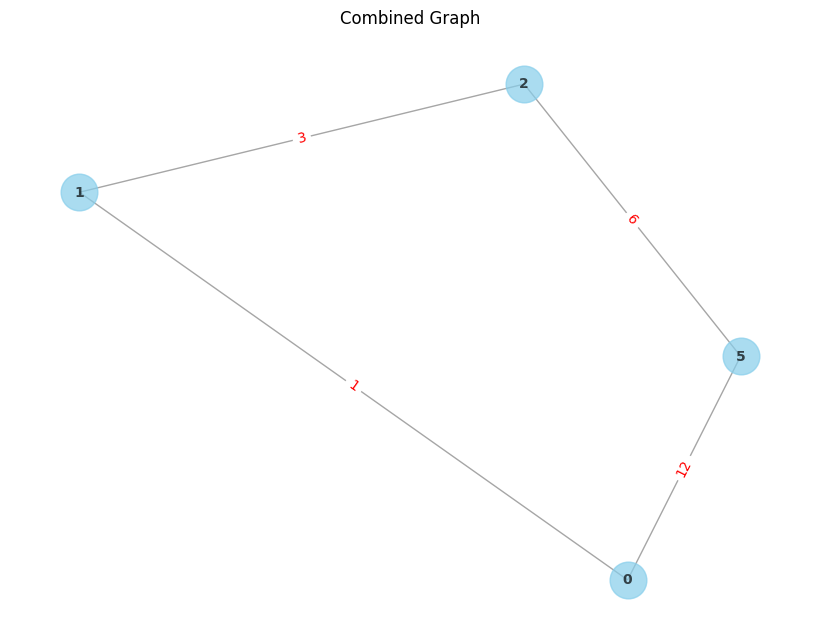

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

truck_path_edges = [(0, 1, 1), (1, 2, 3), (2, 5, 6)]
drone_path_edges = [(0, 5, 12), (2, 5, 6)]

# Create truck graph
truck_G = nx.Graph()
truck_G.add_weighted_edges_from(truck_path_edges)

# Create drone graph
drone_G = nx.Graph()
drone_G.add_weighted_edges_from(drone_path_edges)

# Combine the graphs, resolving common edges with minimum weight
combined_G = nx.Graph()
for edge in set(truck_G.edges).union(drone_G.edges):
    if edge in truck_G.edges and edge in drone_G.edges:
        weight_truck = truck_G[edge[0]][edge[1]]['weight']
        weight_drone = drone_G[edge[0]][edge[1]]['weight']
        min_weight = min(weight_truck, weight_drone)
        combined_G.add_edge(edge[0], edge[1], weight=min_weight)
    elif edge in truck_G.edges:
        combined_G.add_edge(edge[0], edge[1], weight=truck_G[edge[0]][edge[1]]['weight'])
    elif edge in drone_G.edges:
        combined_G.add_edge(edge[0], edge[1], weight=drone_G[edge[0]][edge[1]]['weight'])

# Calculate the shortest paths for delivering to node 2 and node 5
path_node2 = nx.shortest_path(combined_G, source=0, target=2, weight='weight')
path_node5 = nx.shortest_path(combined_G, source=0, target=5, weight='weight')

# Print paths and their costs
print("Path to Node 2:", path_node2)
print("Path to Node 5:", path_node5)

# Calculate the total cost for complete delivery
total_cost_combined = nx.shortest_path_length(combined_G, source=0, target=5, weight='weight')
print("Total cost for complete delivery:", total_cost_combined)

# Plot the combined graph
plt.figure(figsize=(8, 6))
pos_combined = nx.spring_layout(combined_G)
nx.draw(combined_G, pos_combined, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10, edge_color='gray', width=1, alpha=0.7)
edge_labels_combined = nx.get_edge_attributes(combined_G, 'weight')
nx.draw_networkx_edge_labels(combined_G, pos_combined, edge_labels=edge_labels_combined, font_color='red')
plt.title("Combined Graph")
plt.show()


In [4]:
pip install pulp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 53.1 MB/s eta 0:00:00


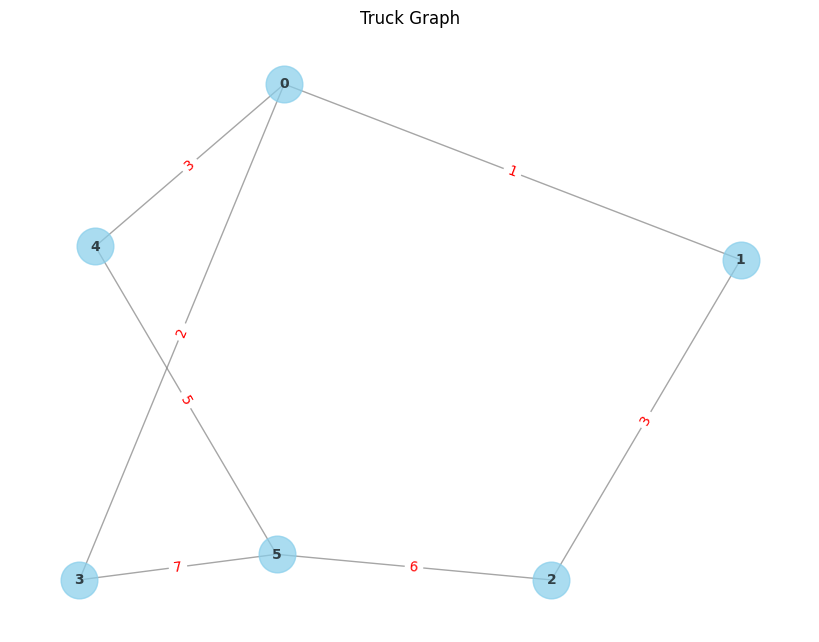

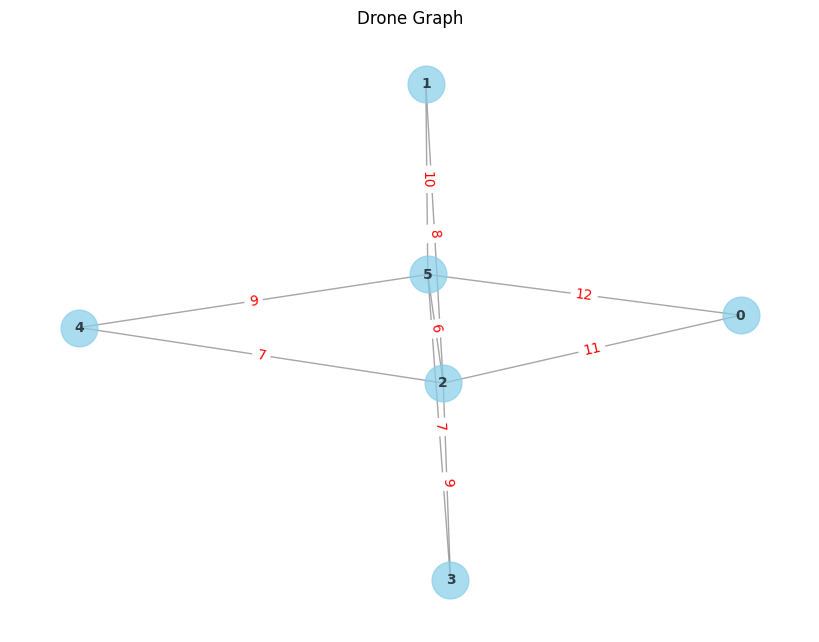

Optimal delivery plan:
Sequence: [(0, 1, 'Truck'), (0, 4, 'Drone'), (0, 2, 'Drone'), (0, 5, 'Truck'), (0, 3, 'Truck'), (1, 2, 'Drone'), (1, 5, 'Drone'), (2, 3, 'Truck'), (2, 5, 'Drone'), (2, 4, 'Drone'), (4, 5, 'Truck'), (5, 3, 'Truck')]


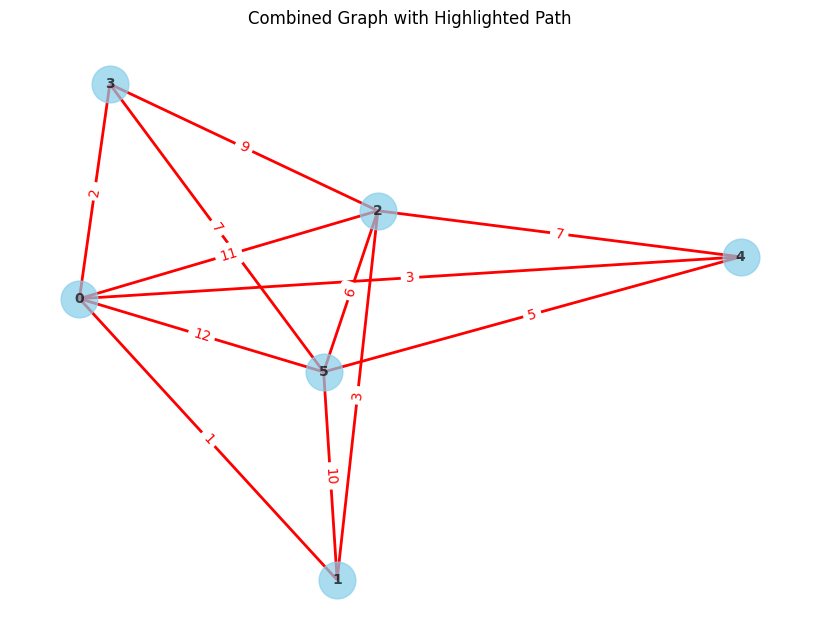

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# Define the edges for the truck and the drone
truck_path_edges = [(0, 1, 1), (1, 2, 3), (2, 5, 6), (0, 3, 2), (3, 5, 7), (0, 4, 3), (4, 5, 5)]
drone_path_edges = [(0, 5, 12), (4, 5, 9), (3, 5, 7), (1, 5, 10), (2, 5, 6), (0, 2, 11), (4, 2, 7), (3, 2, 9), (1, 2, 8), (5, 2, 6)]

# Create truck graph
truck_G = nx.Graph()
truck_G.add_weighted_edges_from(truck_path_edges)

# Create drone graph
drone_G = nx.Graph()
drone_G.add_weighted_edges_from(drone_path_edges)

# Plot truck graph
plt.figure(figsize=(8, 6))
pos_truck = nx.spring_layout(truck_G)
nx.draw(truck_G, pos_truck, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10, edge_color='gray', width=1, alpha=0.7)
edge_labels_truck = nx.get_edge_attributes(truck_G, 'weight')
nx.draw_networkx_edge_labels(truck_G, pos_truck, edge_labels=edge_labels_truck, font_color='red')
plt.title("Truck Graph")
plt.show()

# Plot drone graph
plt.figure(figsize=(8, 6))
pos_drone = nx.spring_layout(drone_G)
nx.draw(drone_G, pos_drone, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10, edge_color='gray', width=1, alpha=0.7)
edge_labels_drone = nx.get_edge_attributes(drone_G, 'weight')
nx.draw_networkx_edge_labels(drone_G, pos_drone, edge_labels=edge_labels_drone, font_color='red')
plt.title("Drone Graph")
plt.show()

# Combine the graphs, resolving common edges with minimum weight
combined_G = nx.Graph()
for edge in set(truck_G.edges).union(drone_G.edges):
    if edge in truck_G.edges and edge in drone_G.edges:
        weight_truck = truck_G[edge[0]][edge[1]]['weight']
        weight_drone = drone_G[edge[0]][edge[1]]['weight']
        min_weight = min(weight_truck, weight_drone)
        combined_G.add_edge(edge[0], edge[1], weight=min_weight)
    elif edge in truck_G.edges:
        combined_G.add_edge(edge[0], edge[1], weight=truck_G[edge[0]][edge[1]]['weight'])
    elif edge in drone_G.edges:
        combined_G.add_edge(edge[0], edge[1], weight=drone_G[edge[0]][edge[1]]['weight'])

# Define the optimization problem
problem = LpProblem("Delivery_Optimization", LpMinimize)

# Define variables for each edge to indicate the proportion of the load carried by the truck
edge_vars_truck = LpVariable.dicts("Truck", combined_G.edges, 0, 1, cat='Continuous')

# Define variables for each edge to indicate the proportion of the load carried by the drone
edge_vars_drone = LpVariable.dicts("Drone", combined_G.edges, 0, 1, cat='Continuous')

# Add constraints to ensure that the combined load proportion is 1 for each edge
for u, v in combined_G.edges:
    problem += edge_vars_truck[u, v] + edge_vars_drone[u, v] == 1

# Add constraints to ensure that nodes 2 and 5 are visited in sequence
problem += edge_vars_truck[1, 2] + edge_vars_drone[1, 2] == 1  # Truck or drone delivers to node 2
problem += edge_vars_truck[2, 5] + edge_vars_drone[2, 5] == 1  # Truck or drone delivers to node 5

# Define objective function (total cost)
problem += lpSum(combined_G[u][v]['weight'] * (edge_vars_truck[u, v] + edge_vars_drone[u, v]) for u, v in combined_G.edges)

# Solve the optimization problem
problem.solve()

# Print the paths and the vehicles taken for each segment
print("Optimal delivery plan:")
sequence = []
for u, v in combined_G.edges:
    truck_load = edge_vars_truck[u, v].value()
    drone_load = edge_vars_drone[u, v].value()
    if truck_load > 0:
        sequence.append((u, v, 'Truck'))
    if drone_load > 0:
        sequence.append((u, v, 'Drone'))
print("Sequence:", sequence)

# Plot the combined graph with highlighted path
plt.figure(figsize=(8, 6))
pos_combined = nx.spring_layout(combined_G)
nx.draw(combined_G, pos_combined, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10, edge_color='gray', width=1, alpha=0.7)

# Highlight the path on the graph
path_edges = [(sequence[i][0], sequence[i][1]) for i in range(len(sequence))]
nx.draw_networkx_edges(combined_G, pos_combined, edgelist=path_edges, edge_color='red', width=2)

edge_labels_combined = nx.get_edge_attributes(combined_G, 'weight')
nx.draw_networkx_edge_labels(combined_G, pos_combined, edge_labels=edge_labels_combined, font_color='red')
plt.title("Combined Graph with Highlighted Path")
plt.show()





